# Scaling Law on MNIST

In this notebook, we explore scaling law on MNIST or fashion-MNIST dataset. We use simple feed-forward neural network as models for our experiments.

By using MNIST dataset and much simpler models, we can easily explore the inside of the scaling law, with much less consumption of time and computational resources. It is like the Aplysia for neural science.

In [1]:
import os
import json
import numpy as np
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import AdamW
from keras.callbacks import EarlyStopping
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import linregress

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Reproducibility
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

2024-03-27 15:33:02.057320: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
EXPERIMENT = {}  # logs the experiment.

## Data

We use fashion-MNIST instead of MNIST, since it is more complicated so that the range of loss can be sufficient large enough for plotting.

In [3]:
# mnist = tf.keras.datasets.mnist
mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32').reshape([-1, 28*28]) / 255.0
x_test = x_test.astype('float32').reshape([-1, 28*28]) / 255.0
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

## Model

While building the model, we minic the strategy of LM (language model). That is, the first hidden layer is a **linear** layer for embedding. By adding or removing this layer, we find that it is essential for producing the scaling law, and it shall be linear. (See below.)

The batch size shall not be too small (such as 32). When batch size is small, the period of validation will be long. The trained model may have been over-fitting.

In [5]:
EXPERIMENT['batch size'] = 2**12  # shall not be too small.


def train_model(hidden_units):
    # Build model.
    layers = []
    layers.append(
        Dense(hidden_units[0])  # embedding.
        # Dense(hidden_units[0], 'relu')  # no embedding.
    )
    for n in hidden_units[1:]:
        layers.append(Dense(n, 'relu'))
    layers.append(Dense(10, 'softmax'))  # output.
    model = Sequential(layers)

    # Compile and train
    model.compile(
        optimizer=AdamW(),
        loss=SparseCategoricalCrossentropy(),
    )
    model.fit(
        x_train, y_train,
        batch_size=EXPERIMENT['batch size'],
        validation_data=(x_test, y_test),
        epochs=10000,  # sufficiently great enough.
        callbacks=[
            EarlyStopping(monitor='val_loss'),
        ],
        verbose=0,
    )
    return model


def get_validation_loss(model):
    y_pred = model(x_test)
    loss_fn = SparseCategoricalCrossentropy()
    return loss_fn(y_test, y_pred)

In [6]:
EXPERIMENT['embed dim'] = 2**11  # shall not be too small.
EXPERIMENT['min log2(n)'] = 4
EXPERIMENT['max log2(n)'] = 12
EXPERIMENT['num log2(n)'] = 10

hidden_units_lst = []
eval_losses = []
for log2_n in tqdm(np.linspace(
    EXPERIMENT['min log2(n)'],
    EXPERIMENT['max log2(n)'],
    EXPERIMENT['num log2(n)'],
)):
    n = int(2**log2_n)
    hidden_units = [EXPERIMENT['embed dim'], n]
    model = train_model(hidden_units)
    eval_loss = get_validation_loss(model)

    hidden_units_lst.append(hidden_units)
    eval_losses.append(eval_loss)

  0%|                                                                     | 0/10 [00:00<?, ?it/s]2024-03-27 15:33:04.343806: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2024-03-27 15:33:04.505226: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
 10%|██████                                                       | 1/10 [00:23<03:27, 23.01s/it]2024-03-27 15:33:27.328472: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2024-03-27 15:33:27.509561: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
100%|████████████████████████████████████████████████████████████| 10/10 [08:54<00:00, 53.41s/it]


## Scaling Law

While computing the number of parameters of model, we find that the strategy of LM is essential too. That is, omitting the embedding. By adding or removing the embedding parameters, we find that it is essential for producing the scaling law. (See below.)

Biases are omitted.

In [7]:
def get_num_params(hidden_units):
    num_params = 0
    # num_params += 28*28 * hidden_units[0]  # shall not add this.
    for n1, n2 in zip(hidden_units[:-1], hidden_units[1:]):
        num_params += n1 * n2
    num_params += hidden_units[-1] * 10  # this will not change the slope.
    return num_params


num_params_lst = [get_num_params(_) for _ in hidden_units_lst]
log_num_params = np.array([np.log2(_) for _ in num_params_lst])
log_num_params

array([15.00702727, 15.86500826, 16.76191477, 17.66523875, 18.56161612,
       19.44997076, 20.34018262, 21.22861439, 22.11751058, 23.00702727])

We use linear regression to test the linearity between the logorithm of loss and logirithm of number of parameters. Linearity is examed by the p-value. The more the p-value closes to zero, the better linearity it has.

In [57]:
def robust_linear_regression(x, y, outliers_sigma=2):
    slope, intercept, *_ = linregress(x, y)
    errors = np.abs(y - (intercept + slope * x))
    min_error = errors.mean() - outliers_sigma * errors.std()
    max_error = errors.mean() + outliers_sigma * errors.std()
    valid_ids, mask = [], []
    for i, e in enumerate(errors):
        if e > min_error and e < max_error:
            valid_ids.append(i)
            mask.append(0)
        else:
            mask.append(1)
    return mask, *linregress(x[valid_ids], y[valid_ids])

In [58]:
log_eval_loss = np.array([np.log2(_) for _ in eval_losses])
# slope, intercept, rvalue, pvalue, stderr = linregress(log_num_params, log_eval_loss)
mask, slope, intercept, rvalue, pvalue, stderr = robust_linear_regression(log_num_params, log_eval_loss)
EXPERIMENT['slope'] = slope
EXPERIMENT['intercept'] = intercept
EXPERIMENT['r-value'] = rvalue
EXPERIMENT['p-value'] = pvalue
EXPERIMENT['stderr'] = stderr

print(f'slope: {slope}, r: {rvalue}, p: {pvalue}, stderr: {stderr}')

slope: -0.06572827545486798, r: -0.9683208635261359, p: 4.2409696381654364e-06, stderr: 0.005992700457226384


In [59]:
log_num_params

array([15.00702727, 15.86500826, 16.76191477, 17.66523875, 18.56161612,
       19.44997076, 20.34018262, 21.22861439, 22.11751058, 23.00702727])

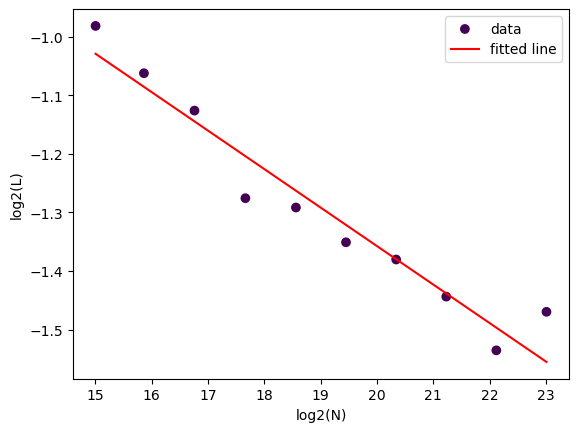

In [60]:
fitted_line = intercept + slope * log_num_params
plt.scatter(log_num_params, log_eval_loss, c=np.array(mask), label='data')
plt.plot(log_num_params, fitted_line, 'r', label='fitted line')
plt.xlabel('log2(N)')
plt.ylabel('log2(L)')
plt.legend()
plt.show()

In [11]:
print(f"""
```json
{json.dumps(EXPERIMENT)}
```
"""
)


```json
{"batch size": 4096, "embed dim": 2048, "min log2(n)": 4, "max log2(n)": 12, "num log2(n)": 10, "slope": -0.06572827545486798, "intercept": -0.04307500549872967, "r-value": -0.9683208635261359, "p-value": 4.2409696381654364e-06, "stderr": 0.005992700457226384}
```



## Logs

```json
{"batch size": 4096, "embed dim": 256, "min log2(n)": 3, "max log2(n)": 10, "num log2(n)": 10, "slope": -0.07210931174580695, "intercept": -0.14903608373359423, "r-value": -0.8683971441398373, "p-value": 0.0011162233975724974, "stderr": 0.014557782438301452}
```

```json
{"batch size": 4096, "embed dim": 512, "min log2(n)": 3, "max log2(n)": 10, "num log2(n)": 10, "slope": -0.09797827591261637, "intercept": 0.3305037767364305, "r-value": -0.9662447040891514, "p-value": 5.453111601752118e-06, "stderr": 0.00923607425156995}
```

```json
{"batch size": 4096, "embed dim": 1024, "min log2(n)": 3, "max log2(n)": 10, "num log2(n)": 10, "slope": -0.0933416698314622, "intercept": 0.3524884570807758, "r-value": -0.9270750520557616, "p-value": 0.00011322993886859013, "stderr": 0.01334452306417338}
```

```json
{"batch size": 4096, "embed dim": 2048, "min log2(n)": 3, "max log2(n)": 10, "num log2(n)": 10, "slope": -0.11601949917283871, "intercept": 0.9038105393539273, "r-value": -0.8657507275808399, "p-value": 0.0012047258515823498, "stderr": 0.023712421592066688}
```

```json
{"batch size": 4096, "embed dim": 2048, "min log2(n)": 4, "max log2(n)": 10, "num log2(n)": 10, "slope": -0.07126320956315887, "intercept": -0.010553154795286401, "r-value": -0.85759098730122, "p-value": 0.0015097749197976616, "stderr": 0.015110678377675844}
```

```json
{"batch size": 4096, "embed dim": 2048, "min log2(n)": 4, "max log2(n)": 12, "num log2(n)": 10, "slope": -0.05938583650237735, "intercept": -0.1329855579677437, "r-value": -0.9702309259201718, "p-value": 1.4557230319936776e-05, "stderr": 0.0056027336122354155}
```

## Conclusion

- Fashion MNIST is a more suitable Aplysia than MNIST.
- The first linear layer (embedding layer) is essential for producing scaling law. It gives an extremely small p-value. While for a non-linear layer as the first, the p-value is significantly large.
- Excluding the parameters in the embedding layer is essential for producing scaling law. It gives an extremely small p-value. While adding these parameters will firnish a significantly large p-value.
- Interestingly, the slope we found on such simple model and dataset also around 0.07, as it is found in language models.